### Sistema Fully Coupled (Girsanov)
$$
\begin{cases}
dS_t =\mu_1(c_1-S_t)dt + \sigma_1dW^1_t\\
dH_t = \mu_2(c_2-H_t)dt + \sigma_2 dW^2_t\\
dV_t = b_V(A_t)dt +\sigma_3 dW^3_t\\
dX_t = V_t dt
\end{cases}
$$
where
$$
b_V(A)=f(A)\Psi(X) + c_3\Psi(-X)-c_4\Psi(X-10)
$$
with
$$\Psi(x)=\max(0,\min(1,x/d,(x_{max}-x)/d))$$ and $f$ a function that we will later choose with care, for now $f=0$$


### Soluzione
$$
    u(t,s,h,v,x) = -\gamma e^s x 
$$

### Equazione backward
$$
 dY_t = -\gamma e^{S_t}\left( X_t \mu_1(c_1-S_t)+V_t +0.5\sigma_1^2X_t \right)dt + Z_t dW_t,
$$
where in the final solution $Z_t = (-\gamma e^{S_t}X_t\sigma_1,0,0,0)$.

In [1]:
## Rete neurale con normalizzazione della loss
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod

class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi, T,
                       M, N, D,
                       layers,
                       t_start=0.0):

        # [MOD] t_start permette di lavorare su intervalli [t_start, t_start+T]
        self.T = T # terminal time (lunghezza del blocco)
        self.t_start = np.float32(t_start) # istante iniziale assoluto del blocco

        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions
        # [MOD] Xi puo' essere (1,D) oppure (M,D); in caso (1,D) lo replichiamo
        self.Xi = self._prepare_Xi(Xi)

        # layers
        self.layers = layers # (D+1) --> 1

        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # tf placeholders and graph (training)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.t_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        # [MOD] Xi passato esplicitamente per traiettoria: M x D
        self.Xi_tf = tf.placeholder(tf.float32, shape=[M, D]) # M x D
        self.const_tf = tf.placeholder(tf.float32, shape=[])
        # [MOD] target terminale esterno opzionale per schema ricorsivo
        self.use_external_terminal_tf = tf.placeholder_with_default(np.float32(0.0), shape=[])
        self.Y_terminal_tf = tf.placeholder_with_default(tf.zeros([M, 1], dtype=tf.float32), shape=[M, 1])
        self.Z_terminal_tf = tf.placeholder_with_default(tf.zeros([M, D], dtype=tf.float32), shape=[M, D])

        self.loss, self.X_pred, self.Y_pred, self.Y0_pred, self.Z_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # optimizers
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)

        # initialize session and variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev), dtype=tf.float32)


    def _prepare_Xi(self, Xi_in):
        # [MOD] Compatibilita': accetta Xi shape (1,D) oppure (M,D)
        Xi_arr = np.asarray(Xi_in, dtype=np.float32)
        if Xi_arr.ndim == 1:
            Xi_arr = Xi_arr.reshape(1, -1)

        if Xi_arr.shape == (1, self.D):
            Xi_arr = np.repeat(Xi_arr, self.M, axis=0)
        elif Xi_arr.shape != (self.M, self.D):
            raise ValueError(
                f"Xi must have shape (1,{self.D}) or ({self.M},{self.D}), got {Xi_arr.shape}"
            )
        return Xi_arr


    def _prepare_terminal_targets(self, Y_terminal, Z_terminal):
        # [MOD] verifica shape target terminali esterni per training ricorsivo
        Y_arr = np.asarray(Y_terminal, dtype=np.float32)
        Z_arr = np.asarray(Z_terminal, dtype=np.float32)

        if Y_arr.ndim == 1:
            Y_arr = Y_arr.reshape(-1, 1)
        if Z_arr.ndim == 1:
            Z_arr = Z_arr.reshape(1, -1)

        if Y_arr.shape != (self.M, 1):
            raise ValueError(f"Y_terminal must have shape ({self.M},1), got {Y_arr.shape}")
        if Z_arr.shape != (self.M, self.D):
            raise ValueError(f"Z_terminal must have shape ({self.M},{self.D}), got {Z_arr.shape}")

        return Y_arr, Z_arr

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X): # M x 1, M x D

        u = self.neural_net(tf.concat([t,X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(u, X)[0] # M x D

        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(self.g_tf(X), X)[0] # M x D

    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, M x D
        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        # [MOD] Xi e' gia' batch di traiettorie iniziali (M x D)
        X0 = Xi # M x D
        Y0, Du0 = self.net_u(t0,X0) # M x 1, M x D
        sigma0 = self.sigma_tf(t0, X0, Y0)
        Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Du0, 1), sigma0), axis=1)

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            dW = W1 - W0
            sigma_dW = tf.squeeze(tf.matmul(sigma0, tf.expand_dims(dW,-1)), axis=[-1])
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + sigma_dW
            # Z = Du*sigma e nella backward compare Z*dW.
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*dW, axis=1, keepdims = True)
            Y1, Du1 = self.net_u(t1,X1)
            sigma1 = self.sigma_tf(t1, X1, Y1)
            Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Du1, 1), sigma1), axis=1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            sigma0 = sigma1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        # [MOD] terminale standard (g, Dg*sigma) oppure esterno (u_{i+1}, z_{i+1})
        Y_terminal_default = self.g_tf(X1)
        Dg = self.Dg_tf(X1)
        Z_terminal_default = tf.squeeze(tf.matmul(tf.expand_dims(Dg, 1), sigma1), axis=1)

        alpha = tf.cast(self.use_external_terminal_tf, tf.float32)
        Y_terminal_target = (1.0 - alpha) * Y_terminal_default + alpha * self.Y_terminal_tf
        Z_terminal_target = (1.0 - alpha) * Z_terminal_default + alpha * self.Z_terminal_tf

        loss += tf.reduce_sum(tf.square(Y1 - Y_terminal_target))
        loss += tf.reduce_sum(tf.square(Z1 - Z_terminal_target))

        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)
        Z = tf.stack(Z_list,axis=1)

        # [MOD] Y0_pred ora e' vettoriale: (M,1)
        return loss/self.N, X, Y, Y[:,0,:], Z

    def fetch_minibatch(self):
        T = self.T
        t_start = self.t_start

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        # [MOD] tempi assoluti nel blocco: [t_start, t_start + T]
        t = t_start + np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D

        return t, W

    def train(self, N_Iter, learning_rate, const_value=None,
              Xi_batch=None, fixed_batch=None, terminal_targets=None):

        # [MOD] Xi_batch permette training per blocco con Xi = X_{t_i}
        Xi_feed = self.Xi if Xi_batch is None else self._prepare_Xi(Xi_batch)

        # [MOD] fixed_batch=(t_batch, W_batch) blocca i campioni Browniani del sottointervallo
        if fixed_batch is not None:
            t_fixed, W_fixed = fixed_batch
            t_fixed = np.asarray(t_fixed, dtype=np.float32)
            W_fixed = np.asarray(W_fixed, dtype=np.float32)
            if t_fixed.shape != (self.M, self.N+1, 1):
                raise ValueError(f"t_batch must have shape ({self.M},{self.N+1},1), got {t_fixed.shape}")
            if W_fixed.shape != (self.M, self.N+1, self.D):
                raise ValueError(f"W_batch must have shape ({self.M},{self.N+1},{self.D}), got {W_fixed.shape}")

        use_external_terminal = np.float32(0.0)
        Y_terminal_feed = np.zeros((self.M, 1), dtype=np.float32)
        Z_terminal_feed = np.zeros((self.M, self.D), dtype=np.float32)
        if terminal_targets is not None:
            use_external_terminal = np.float32(1.0)
            Y_terminal_feed, Z_terminal_feed = self._prepare_terminal_targets(
                terminal_targets[0], terminal_targets[1]
            )

        start_time = time.time()
        last_loss = None
        last_y0 = None
        current_const = np.float32(self.const if const_value is None else const_value)
        for it in range(N_Iter):

            if fixed_batch is None:
                t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D
            else:
                t_batch, W_batch = t_fixed, W_fixed

            tf_dict = {
                self.Xi_tf: Xi_feed,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.learning_rate: learning_rate,
                self.const_tf: current_const,
                self.use_external_terminal_tf: use_external_terminal,
                self.Y_terminal_tf: Y_terminal_feed,
                self.Z_terminal_tf: Z_terminal_feed,
            }

            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                # [MOD] Y0 e' vettoriale su M traiettorie: logghiamo media e deviazione std
                y0_mean = float(np.mean(Y0_value))
                y0_std = float(np.std(Y0_value))
                last_loss = float(loss_value)
                last_y0 = y0_mean
                print('It: %d, Loss: %.3e, Y0_mean: %.3f, Y0_std: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, y0_mean, y0_std, elapsed, learning_rate_value))
                start_time = time.time()

        return {
            'const': float(current_const),
            'learning_rate': float(learning_rate),
            'n_iter': int(N_Iter),
            'last_loss': last_loss,
            'last_y0': last_y0,
            'use_external_terminal': bool(use_external_terminal > 0.5),
        }


    def evaluate(self, const_value=None, n_batches=5,
                 Xi_batch=None, fixed_batch=None, terminal_targets=None):
        current_const = np.float32(self.const if const_value is None else const_value)
        Xi_feed = self.Xi if Xi_batch is None else self._prepare_Xi(Xi_batch)

        use_external_terminal = np.float32(0.0)
        Y_terminal_feed = np.zeros((self.M, 1), dtype=np.float32)
        Z_terminal_feed = np.zeros((self.M, self.D), dtype=np.float32)
        if terminal_targets is not None:
            use_external_terminal = np.float32(1.0)
            Y_terminal_feed, Z_terminal_feed = self._prepare_terminal_targets(
                terminal_targets[0], terminal_targets[1]
            )

        if fixed_batch is not None:
            t_fixed, W_fixed = fixed_batch
            t_fixed = np.asarray(t_fixed, dtype=np.float32)
            W_fixed = np.asarray(W_fixed, dtype=np.float32)

        losses = []
        y0s = []
        for _ in range(n_batches):
            if fixed_batch is None:
                t_batch, W_batch = self.fetch_minibatch()
            else:
                t_batch, W_batch = t_fixed, W_fixed

            tf_dict = {
                self.Xi_tf: Xi_feed,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.const_tf: current_const,
                self.use_external_terminal_tf: use_external_terminal,
                self.Y_terminal_tf: Y_terminal_feed,
                self.Z_terminal_tf: Z_terminal_feed,
            }
            loss_value, y0_value = self.sess.run([self.loss, self.Y0_pred], tf_dict)
            losses.append(float(loss_value))
            # [MOD] y0_value shape (M,1): usiamo la media batch per statistica tra batch
            y0s.append(float(np.mean(y0_value)))

        return {
            'const': float(current_const),
            'mean_loss': float(np.mean(losses)),
            'std_loss': float(np.std(losses)),
            'mean_y0': float(np.mean(y0s)),
            'std_y0': float(np.std(y0s)),
            'n_batches': int(n_batches),
            'use_external_terminal': bool(use_external_terminal > 0.5),
        }


    def predict(self, Xi_star, t_star, W_star, const_value=None):

        current_const = np.float32(self.const if const_value is None else const_value)
        Xi_star = self._prepare_Xi(Xi_star)
        tf_dict = {
            self.Xi_tf: Xi_star,
            self.t_tf: t_star,
            self.W_tf: W_star,
            self.const_tf: current_const,
            self.use_external_terminal_tf: np.float32(0.0),
        }

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)

        return X_star, Y_star, Z_star

    def export_parameters(self):
        # [MOD] esporta pesi/bias per warm-start tra blocchi ricorsivi
        return self.sess.run(self.weights + self.biases)

    def import_parameters(self, values):
        # [MOD] importa pesi/bias compatibili per warm-start
        if len(values) != len(self.weights) + len(self.biases):
            raise ValueError("Invalid number of tensors for import_parameters")
        vars_all = self.weights + self.biases
        assign_ops = [var.assign(val) for var, val in zip(vars_all, values)]
        self.sess.run(assign_ops)


    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1

    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M,D])) # M x D x D
    ###########################################################################

In [2]:
class NN(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, parameters, t_start=0.0):
        self.mu1 = parameters['mu1']
        self.mu2 = parameters['mu2']
        self.c1 = parameters['c1']
        self.c2 = parameters['c2']
        self.c3 = parameters['c3']
        self.c4 = parameters['c4']
        self.gamma = parameters['gamma']
        self.s1 = parameters['s1']
        self.s2 = parameters['s2']
        self.s3 = parameters['s3']
        self.x_max = parameters['x_max']
        self.d = parameters['d']
        self.const = parameters['const']
        super().__init__(Xi, T, M, N, D, layers, t_start=t_start)

    def psi(self,X_state):
        #S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        result = tf.maximum(0.0,
                   tf.minimum(
                     1.0,
                     tf.minimum(X_state/self.d, (self.x_max - X_state)/self.d)
                     )
                 )
        return result
    
    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)
        c4 = tf.cast(self.c4, tf.float32)
        x_max = tf.cast(self.x_max, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = c3 * self.psi(-X_state) - c4 * self.psi(X_state-x_max)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        gamma = tf.cast(self.gamma, tf.float32)
        exp_S = tf.exp(S)
        return -gamma * exp_S * X_state

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu1 = tf.cast(self.mu1, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        s1 = tf.cast(self.s1, tf.float32)
        gamma = tf.cast(self.gamma, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        
        exp_S = tf.exp(S)

        return - gamma * exp_S * ( X_state * mu1 * (c1-S) + V + 0.5 * X_state * s1**2 )
    
    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        return tf.stack([r1, r2, r3, r4], axis=1)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


=== Recursive training (backward in time) ===
[RecursiveConfigAdjust] label=main:quick: n_blocks 6 -> 2 (N_total=10, min_steps_per_block=4)
[RecursiveConfig] label=main:quick, N_total=10, n_blocks=2 (req=6), min_steps_per_block=4, terminal_min_steps=6, iters_per_block=120, lr=7.0e-04, warm_start=True
[RecursivePartition] label=main:quick, steps=[4, 6]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

[RecursiveBlock] main:quick b=1, idx=[4,10], steps=6, terminal=g, iters=720, lr=1.7e-04
[TerminalSchedule] main:quick b=1: stage1(iters=252, lr=5.2e-04), stage2(iters=468, lr=1.7e-04)
It: 0, Loss: 2.792e+04, Y0_mean: -0.839, Y0_std: 0.040, Time: 2.37, Learning Rate: 5.250e-04
It: 10, Loss: 1.026e+04, Y0_mean: -10.290, Y0_std: 0.382, Time: 0.11, Learning Rat

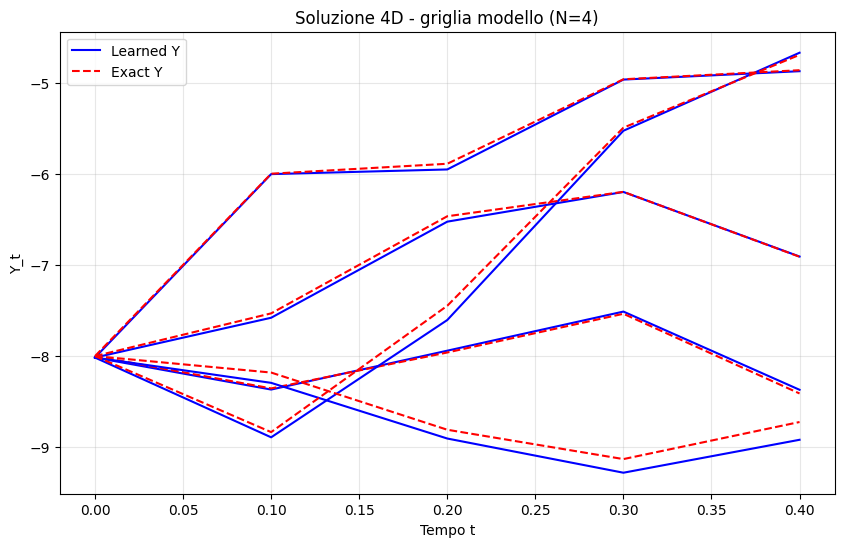

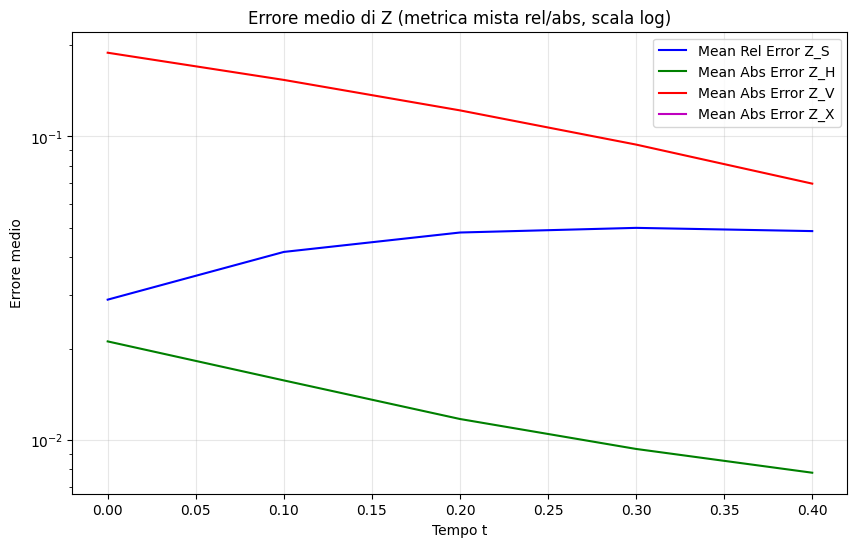

In [3]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    M = 2048
    N = 10
    D = 4
    T = 1.0

    params = {
        'mu1': np.float32(1.0),
        'mu2': np.float32(1.0),
        'c1': np.float32(1.0),
        'c2': np.float32(1.0),
        'c3': np.float32(1.0),
        'c4': np.float32(1.0),
        'gamma': np.float32(1.0),
        'd': np.float32(1.0),
        'x_max': np.float32(1.0),
        's1': np.float32(0.5),
        's2': np.float32(0.5),
        's3': np.float32(0.5),
        # Soft-init: partenza disaccoppiata
        'const': np.float32(0.0),
    }

    # [MOD] Xi puo' essere (1,D) o (M,D); qui usiamo (1,D) e la classe lo espande a (M,D)
    Xi = np.array([np.log(4), 0.5, 0.5, 2.0]).reshape(1, D)

    layers = [D+1] + 4*[256] + [1]

    model = NN(Xi, T, M, N, D, layers, params)

    # [MOD] ===================== SCHEMA RICORSIVO A SOTTOINTERVALLI =====================
    # [MOD] Idea: simuliamo una sola volta forward la dinamica (indipendente da Y,Z),
    # [MOD] poi alleniamo backward per blocchi: ultimo blocco con g, blocchi precedenti con target u_{i+1}.

    def psi_np(x_state, d, x_max):
        return np.maximum(0.0, np.minimum(1.0, np.minimum(x_state / d, (x_max - x_state) / d)))

    def simulate_forward_paths_np(Xi_batch, params_local, T_total, N_total, seed=1234):
        rng = np.random.RandomState(seed)
        M_local, D_local = Xi_batch.shape
        dt = T_total / N_total

        t_grid = np.linspace(0.0, T_total, N_total + 1, dtype=np.float32)
        dW = (np.sqrt(dt) * rng.normal(size=(M_local, N_total, D_local))).astype(np.float32)

        X_paths = np.zeros((M_local, N_total + 1, D_local), dtype=np.float32)
        X_paths[:, 0, :] = Xi_batch.astype(np.float32)

        mu1 = float(params_local['mu1'])
        mu2 = float(params_local['mu2'])
        c1 = float(params_local['c1'])
        c2 = float(params_local['c2'])
        c3 = float(params_local['c3'])
        c4 = float(params_local['c4'])
        d_par = float(params_local['d'])
        x_max = float(params_local['x_max'])
        s1 = float(params_local['s1'])
        s2 = float(params_local['s2'])
        s3 = float(params_local['s3'])

        for n in range(N_total):
            Xn = X_paths[:, n, :]
            S = Xn[:, 0:1]
            H = Xn[:, 1:2]
            V = Xn[:, 2:3]
            X_state = Xn[:, 3:4]

            dS = mu1 * (c1 - S)
            dH = mu2 * (c2 - H)
            dV = c3 * psi_np(-X_state, d_par, x_max) - c4 * psi_np(X_state - x_max, d_par, x_max)
            dX = V
            drift = np.concatenate([dS, dH, dV, dX], axis=1)

            diffusion = np.zeros_like(Xn)
            diffusion[:, 0:1] = s1 * dW[:, n, 0:1]
            diffusion[:, 1:2] = s2 * dW[:, n, 1:2]
            diffusion[:, 2:3] = s3 * dW[:, n, 2:3]
            diffusion[:, 3:4] = 0.0

            X_paths[:, n + 1, :] = Xn + drift * dt + diffusion

        return t_grid, dW, X_paths

    def build_block_batch_from_forward(t_grid, dW, i0, i1):
        # [MOD] Costruisce (t, W) locali del blocco [i0, i1] con W locale che parte da zero
        M_local = dW.shape[0]
        D_local = dW.shape[2]
        n_steps = i1 - i0
        t_block = np.zeros((M_local, n_steps + 1, 1), dtype=np.float32)
        W_block = np.zeros((M_local, n_steps + 1, D_local), dtype=np.float32)

        t_block[:, :, 0] = t_grid[i0:i1 + 1][None, :]
        W_block[:, 1:, :] = np.cumsum(dW[:, i0:i1, :], axis=1)
        return t_block, W_block

    def build_dummy_batch_for_model(model_local):
        # [MOD] Batch dummy per estrarre u(t_start, x) e z(t_start, x) via predict
        t_dummy = np.zeros((model_local.M, model_local.N + 1, 1), dtype=np.float32)
        local_grid = np.linspace(
            float(model_local.t_start),
            float(model_local.t_start + model_local.T),
            model_local.N + 1,
            dtype=np.float32,
        )
        t_dummy[:, :, 0] = local_grid[None, :]
        W_dummy = np.zeros((model_local.M, model_local.N + 1, model_local.D), dtype=np.float32)
        return t_dummy, W_dummy

    run_recursive = True
    # [MOD] Profili pronti: 'quick' per test veloce, 'stable' per run piu' robusto
    recursive_profile = 'quick'  # cambia in 'stable' per training piu' accurato
    if recursive_profile == 'quick':
        recursive_cfg = {
            'n_blocks': 6,
            'iters_per_block': 120,
            'lr_per_block': 7e-4,
            'seed_forward': 1234,
            'use_warm_start': True,
            # [MOD] evita blocchi troppo corti quando N_total e' piccolo
            'min_steps_per_block': 4,
            # [MOD] terminal block (con g) piu' difficile: alleniamo di piu' con LR ridotto
            'terminal_iters_multiplier': 6.0,
            'terminal_lr_multiplier': 0.25,
            # [MOD] mini-schedule a 2 stadi nel terminal block
            'terminal_two_stage': True,
            'terminal_stage1_frac': 0.35,
            'terminal_stage1_lr_boost': 3.0,
            # [MOD] forziamo piu' steps sul blocco terminale quando possibile
            'terminal_min_steps': 6,
        }
    elif recursive_profile == 'stable':
        recursive_cfg = {
            'n_blocks': 10,
            'iters_per_block': 350,
            'lr_per_block': 3e-4,
            'seed_forward': 1234,
            'use_warm_start': True,
            # [MOD] evita blocchi troppo corti quando N_total e' piccolo
            'min_steps_per_block': 4,
            # [MOD] anche in stable rafforziamo il terminal block
            'terminal_iters_multiplier': 4.0,
            'terminal_lr_multiplier': 0.25,
            # [MOD] mini-schedule a 2 stadi nel terminal block
            'terminal_two_stage': True,
            'terminal_stage1_frac': 0.30,
            'terminal_stage1_lr_boost': 2.5,
            # [MOD] forziamo piu' steps sul blocco terminale quando possibile
            'terminal_min_steps': 8,
        }
    else:
        raise ValueError("recursive_profile must be 'quick' or 'stable'")

    recursive_logs = []
    recursive_models = []

    if run_recursive:
        def run_recursive_experiment(Xi_seed, N_total, T_total, cfg, label, keep_model=False):
            # [MOD] helper unico per training ricorsivo: usato sia run principale che benchmark N basso
            Xi_batch_local = np.repeat(Xi_seed.astype(np.float32), M, axis=0)
            t_grid_all, dW_all, X_paths_all = simulate_forward_paths_np(
                Xi_batch_local, params, T_total, N_total, seed=cfg['seed_forward']
            )

            # [MOD] adatta automaticamente il numero di blocchi per evitare blocchi con pochissimi step
            min_steps = int(cfg.get('min_steps_per_block', 1))
            requested_blocks = int(cfg['n_blocks'])
            max_blocks_from_steps = max(1, N_total // max(1, min_steps))
            effective_blocks = min(requested_blocks, max_blocks_from_steps)
            if effective_blocks < requested_blocks:
                print(
                    f"[RecursiveConfigAdjust] label={label}: n_blocks {requested_blocks} -> {effective_blocks} "
                    f"(N_total={N_total}, min_steps_per_block={min_steps})"
                )

            # [MOD] partizione con minimo steps per blocco e priorita' al blocco terminale
            terminal_min_steps = int(cfg.get('terminal_min_steps', min_steps))
            steps = [min_steps for _ in range(effective_blocks)]
            remaining_steps = int(N_total - effective_blocks * min_steps)

            # assegna quanti piu' step possibili al terminale (entro il target)
            extra_for_terminal = min(remaining_steps, max(0, terminal_min_steps - min_steps))
            steps[-1] += extra_for_terminal
            remaining_steps -= extra_for_terminal

            # distribuisci il resto sugli altri blocchi (round-robin) per evitare squilibri estremi
            if effective_blocks > 1:
                k = 0
                while remaining_steps > 0:
                    steps[k % (effective_blocks - 1)] += 1
                    k += 1
                    remaining_steps -= 1
            else:
                steps[0] += remaining_steps

            block_edges = np.zeros(effective_blocks + 1, dtype=int)
            for i_step in range(effective_blocks):
                block_edges[i_step + 1] = block_edges[i_step] + steps[i_step]

            if block_edges[-1] != N_total:
                raise ValueError(f"[{label}] invalid block partition: last edge {block_edges[-1]} != N_total {N_total}")

            next_model = None
            next_params = None
            local_logs = []
            local_models = []

            print(
                f"[RecursiveConfig] label={label}, N_total={N_total}, n_blocks={effective_blocks} (req={requested_blocks}), "
                f"min_steps_per_block={min_steps}, terminal_min_steps={terminal_min_steps}, "
                f"iters_per_block={cfg['iters_per_block']}, lr={cfg['lr_per_block']:.1e}, warm_start={cfg['use_warm_start']}"
            )
            print(f"[RecursivePartition] label={label}, steps={steps}")

            for b in range(effective_blocks - 1, -1, -1):  # [MOD] usa il numero di blocchi effettivo
                i0 = int(block_edges[b])
                i1 = int(block_edges[b + 1])
                n_steps_block = i1 - i0

                Xi_block = X_paths_all[:, i0, :]
                X_terminal = X_paths_all[:, i1, :]
                t_block, W_block = build_block_batch_from_forward(t_grid_all, dW_all, i0, i1)

                T_block = float(t_grid_all[i1] - t_grid_all[i0])
                t_start_block = float(t_grid_all[i0])

                block_model = NN(
                    Xi=Xi_block,
                    T=T_block,
                    M=M,
                    N=n_steps_block,
                    D=D,
                    layers=layers,
                    parameters=params,
                    t_start=t_start_block,
                )

                if cfg['use_warm_start'] and (next_params is not None):
                    block_model.import_parameters(next_params)

                terminal_targets = None
                if next_model is not None:
                    t_dummy_next, W_dummy_next = build_dummy_batch_for_model(next_model)
                    _, Y_next, Z_next = next_model.predict(
                        X_terminal, t_dummy_next, W_dummy_next, const_value=1.0
                    )
                    terminal_targets = (Y_next[:, 0, :], Z_next[:, 0, :])

                # [MOD] terminal block (target g) allenato con schedule piu' robusta
                is_terminal_block = (terminal_targets is None)
                block_iters = int(cfg['iters_per_block'])
                block_lr = float(cfg['lr_per_block'])
                if is_terminal_block:
                    block_iters = int(max(1, round(block_iters * float(cfg.get('terminal_iters_multiplier', 1.0)))))
                    block_lr = float(block_lr * float(cfg.get('terminal_lr_multiplier', 1.0)))

                print(
                    f"[RecursiveBlock] {label} b={b}, idx=[{i0},{i1}], steps={n_steps_block}, "
                    f"terminal={'external' if terminal_targets is not None else 'g'}, "
                    f"iters={block_iters}, lr={block_lr:.1e}"
                )

                # [MOD] mini-schedule a 2 stadi sul terminal block per maggiore robustezza
                if is_terminal_block and bool(cfg.get('terminal_two_stage', False)):
                    stage1_frac = float(cfg.get('terminal_stage1_frac', 0.3))
                    stage1_iters = int(max(1, round(block_iters * stage1_frac)))
                    stage2_iters = int(max(1, block_iters - stage1_iters))
                    stage1_lr = float(block_lr * float(cfg.get('terminal_stage1_lr_boost', 1.0)))
                    stage2_lr = float(block_lr)

                    print(
                        f"[TerminalSchedule] {label} b={b}: "
                        f"stage1(iters={stage1_iters}, lr={stage1_lr:.1e}), "
                        f"stage2(iters={stage2_iters}, lr={stage2_lr:.1e})"
                    )

                    block_model.train(
                        N_Iter=stage1_iters,
                        learning_rate=stage1_lr,
                        const_value=1.0,
                        Xi_batch=Xi_block,
                        fixed_batch=(t_block, W_block),
                        terminal_targets=terminal_targets,
                    )
                    train_stats_block = block_model.train(
                        N_Iter=stage2_iters,
                        learning_rate=stage2_lr,
                        const_value=1.0,
                        Xi_batch=Xi_block,
                        fixed_batch=(t_block, W_block),
                        terminal_targets=terminal_targets,
                    )
                else:
                    train_stats_block = block_model.train(
                        N_Iter=block_iters,
                        learning_rate=block_lr,
                        const_value=1.0,
                        Xi_batch=Xi_block,
                        fixed_batch=(t_block, W_block),
                        terminal_targets=terminal_targets,
                    )
                eval_stats_block = block_model.evaluate(
                    const_value=1.0,
                    n_batches=1,
                    Xi_batch=Xi_block,
                    fixed_batch=(t_block, W_block),
                    terminal_targets=terminal_targets,
                )

                local_logs.append({
                    'block': int(b),
                    'i0': int(i0),
                    'i1': int(i1),
                    'steps': int(n_steps_block),
                    'train_last_loss': train_stats_block['last_loss'],
                    'eval_loss': eval_stats_block['mean_loss'],
                    'eval_y0': eval_stats_block['mean_y0'],
                    'terminal_mode': 'external' if terminal_targets is not None else 'g',
                    # [MOD] trace esplicito del budget usato nel blocco
                    'train_iters': int(block_iters),
                    'train_lr': float(block_lr),
                })

                local_models.append(block_model)
                next_model = block_model
                next_params = block_model.export_parameters()

            model_t0 = local_models[-1]
            ordered_logs = sorted(local_logs, key=lambda x: x['block'])
            # [MOD] summary separato: terminal block vs blocchi esterni
            terminal_losses = [r['eval_loss'] for r in ordered_logs if r['terminal_mode'] == 'g']
            non_terminal_losses = [r['eval_loss'] for r in ordered_logs if r['terminal_mode'] != 'g']

            summary = {
                'label': label,
                'N_total': int(N_total),
                'mean_eval_loss': float(np.mean([r['eval_loss'] for r in ordered_logs])),
                'std_eval_loss': float(np.std([r['eval_loss'] for r in ordered_logs])),
                'mean_eval_loss_nonterminal': float(np.mean(non_terminal_losses)) if len(non_terminal_losses) > 0 else float('nan'),
                'terminal_eval_loss': float(np.mean(terminal_losses)) if len(terminal_losses) > 0 else float('nan'),
                'block0_eval_y0': float(ordered_logs[0]['eval_y0']),
                'n_blocks': int(len(ordered_logs)),
            }

            if keep_model:
                for m in local_models[:-1]:
                    m.sess.close()
                return summary, ordered_logs, model_t0

            for m in local_models:
                m.sess.close()
            return summary, ordered_logs, None

        print("\n=== Recursive training (backward in time) ===")
        main_summary, recursive_logs, recursive_model_t0 = run_recursive_experiment(
            Xi_seed=Xi,
            N_total=N,
            T_total=T,
            cfg=recursive_cfg,
            label=f"main:{recursive_profile}",
            keep_model=True,
        )

        print("=== Recursive Log (compact) ===")
        for row in recursive_logs:
            print(
                f"block={row['block']}, idx=[{row['i0']},{row['i1']}], steps={row['steps']}, "
                f"terminal={row['terminal_mode']}, eval_loss={row['eval_loss']:.3e}, eval_y0={row['eval_y0']:.3f}"
            )

        # [MOD] benchmark rapido stabilita' con N ridotto e confronto quick/stable
        run_lowN_benchmark = True
        benchmark_N_values = [20, 30]
        benchmark_cfg_by_profile = {
            'quick': {
                'n_blocks': 4,
                'iters_per_block': 70,
                'lr_per_block': 8e-4,
                'seed_forward': 4321,
                'use_warm_start': True,
                'min_steps_per_block': 4,
                # [MOD] robustezza terminale anche nei benchmark
                'terminal_iters_multiplier': 4.0,
                'terminal_lr_multiplier': 0.25,
                'terminal_two_stage': True,
                'terminal_stage1_frac': 0.35,
                'terminal_stage1_lr_boost': 2.5,
                'terminal_min_steps': 6,
            },
            'stable': {
                'n_blocks': 6,
                'iters_per_block': 160,
                'lr_per_block': 3e-4,
                'seed_forward': 4321,
                'use_warm_start': True,
                'min_steps_per_block': 4,
                # [MOD] robustezza terminale anche nei benchmark
                'terminal_iters_multiplier': 3.0,
                'terminal_lr_multiplier': 0.25,
                'terminal_two_stage': True,
                'terminal_stage1_frac': 0.30,
                'terminal_stage1_lr_boost': 2.0,
                'terminal_min_steps': 6,
            },
        }

        benchmark_summaries = []
        if run_lowN_benchmark:
            print("\n=== Low-N Recursive Benchmark (quick vs stable) ===")
            for N_low in benchmark_N_values:
                for prof in ['quick', 'stable']:
                    cfg_low = benchmark_cfg_by_profile[prof]
                    summary_low, _, _ = run_recursive_experiment(
                        Xi_seed=Xi,
                        N_total=N_low,
                        T_total=T,
                        cfg=cfg_low,
                        label=f"bench:{prof}:N={N_low}",
                        keep_model=False,
                    )
                    summary_low['profile'] = prof
                    benchmark_summaries.append(summary_low)

            print("=== Benchmark Summary (compact) ===")
            for row in benchmark_summaries:
                print(
                    f"profile={row['profile']}, N={row['N_total']}, n_blocks={row['n_blocks']}, "
                    f"mean_eval_loss={row['mean_eval_loss']:.3e}±{row['std_eval_loss']:.2e}, "
                    f"mean_nonterm={row['mean_eval_loss_nonterminal']:.3e}, terminal={row['terminal_eval_loss']:.3e}, "
                    f"block0_eval_y0={row['block0_eval_y0']:.3f}"
                )

        # [MOD] usiamo il modello ricorsivo iniziale per il plotting finale
        model = recursive_model_t0

    
    # --- PLOTTING ---
    # [MOD] usa sempre la discretizzazione del modello attuale (globale o blocco ricorsivo)
    M_plot = model.M
    N_plot = model.N

    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(model.Xi, t_test, W_test)

    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]
        return -params['gamma'] * np.exp(S) * X_state

    def z_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]

        s1 = params['s1']
        z_s = -params['gamma'] * np.exp(S) * X_state * s1
        z_h = np.zeros_like(z_s)
        z_v = np.zeros_like(z_s)
        z_x = np.zeros_like(z_s)

        return np.concatenate([z_s, z_h, z_v, z_x], axis=1)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)

    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M_plot, N_plot + 1, 1)
    Z_exact = z_exact(t_reshaped, Xi_reshaped).reshape(M_plot, N_plot + 1, D)

    exact_Y0 = u_exact(np.array([[float(model.t_start)]], dtype=np.float32), model.Xi[:1])[0, 0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")

    n_show = min(5, M_plot)
    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    if n_show > 1:
        plt.plot(t_test[1:n_show,:,0].T, Y_pred[1:n_show,:,0].T, 'b')
        plt.plot(t_test[1:n_show,:,0].T, Y_exact[1:n_show,:,0].T, 'r--')
    plt.title(f"Soluzione 4D - griglia modello (N={N_plot})")
    plt.xlabel("Tempo t")
    plt.ylabel("Y_t")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # [MOD] metrica Z robusta: relativa su componenti con target non nullo,
    # [MOD] assoluta su componenti con target ~0 (altrimenti la relativa esplode artificialmente).
    eps = 1e-8
    rel_err_Z = np.abs((Z_pred - Z_exact) / (np.abs(Z_exact) + eps))
    abs_err_Z = np.abs(Z_pred - Z_exact)

    mean_rel_err_Z = np.mean(rel_err_Z, axis=0)  # (N_plot+1, D)
    mean_abs_err_Z = np.mean(abs_err_Z, axis=0)  # (N_plot+1, D)

    # [MOD] rileva componenti quasi nulle nel target esatto
    z_scale = np.mean(np.abs(Z_exact), axis=(0, 1))  # (D,)
    near_zero_target = z_scale < 1e-5

    labels = ['Z_S', 'Z_H', 'Z_V', 'Z_X']
    colors = ['b', 'g', 'r', 'm']

    plt.figure(figsize=(10,6))
    for d in range(D):
        if near_zero_target[d]:
            plt.plot(t_test[0,:,0], mean_abs_err_Z[:, d], colors[d], label=f'Mean Abs Error {labels[d]}')
        else:
            plt.plot(t_test[0,:,0], mean_rel_err_Z[:, d], colors[d], label=f'Mean Rel Error {labels[d]}')
    plt.yscale('log')
    plt.title('Errore medio di Z (metrica mista rel/abs, scala log)')
    plt.xlabel('Tempo t')
    plt.ylabel('Errore medio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
